In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
DEMAND_DATA = os.path.join("/Users/andika/Desktop/PROJECT/MACHINELEARNING/datasets", "housing")


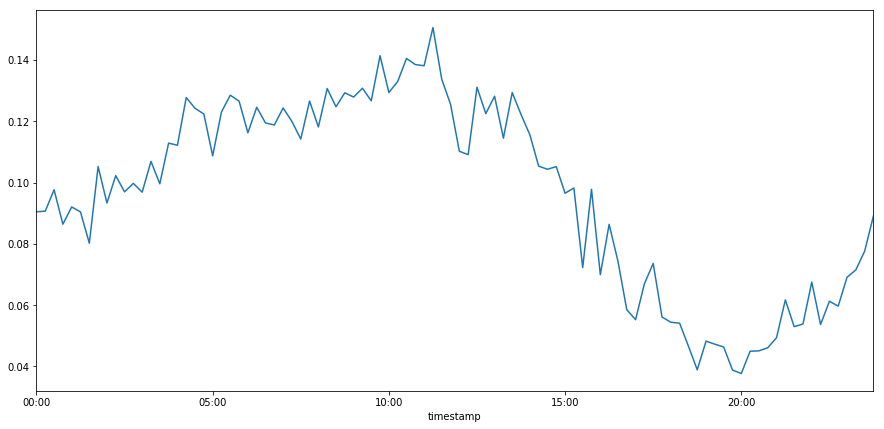

In [2]:
def load_data(path=DEMAND_DATA):
    csv_path = os.path.join(path, "GRAB_traffic_data_training.csv")
    return pd.read_csv(csv_path)

def zero_padding_timestamp(x):
    h,m = map(str,x.split(':'))
    h = h.zfill(2)
    m = m.rjust(2,'0')
    return h+":"+m

def feature_hour(x):
    h,m = map(str,x.split(':'))
    return float(h)


traffic_all = load_data()
traffic_all['hour'] = traffic_all['timestamp'].apply(feature_hour)
traffic_all['timestamp'] = traffic_all['timestamp'].apply(zero_padding_timestamp)

#create small set for quick analysis
#traffic_toy = traffic_all.sample(frac =.05) 
traffic_all = traffic_all.sample(frac =.01) 

#plotting mean of hourly data
fig, ax = plt.subplots(figsize=(15,7))
traffic_all.groupby('timestamp').mean()['demand'].plot(kind='line')


We observed a high level of demand starting 5AM, peaking at 10AM. This is expected since those 
are the time where people are in a hurry for work.

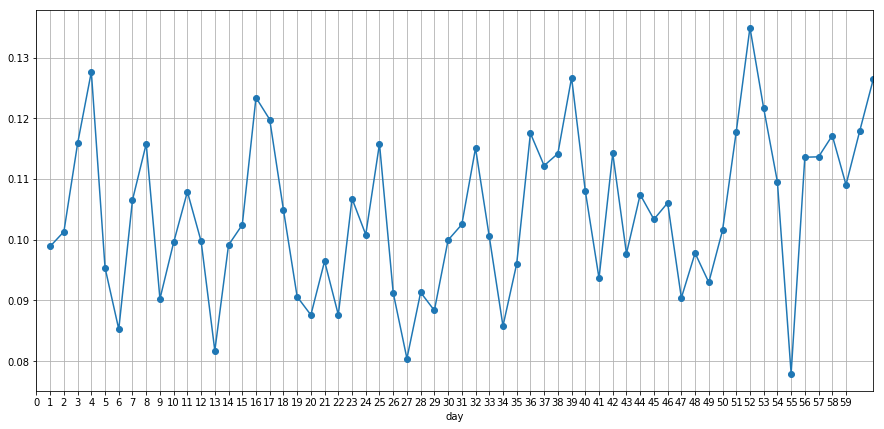

In [3]:
#investigate daily/weekly pattern
fig, ax = plt.subplots(figsize=(15,7))
daily_ticks = 1*np.arange(60)
traffic_all.groupby(['day']).mean()['demand'].plot(kind='line',xticks=daily_ticks,marker='o',grid=True)

Although we are not sure the exact day, we can see a strong pattern in term of cyclical days, suspected to be weekly.
Lowest demand is consistently on day 6,13,20,...55, the 6th day of week, possibly Sunday or Saturday
High demand is on 4,11,18,25... 60. the 4th day of the week, possibly Friday or Monday

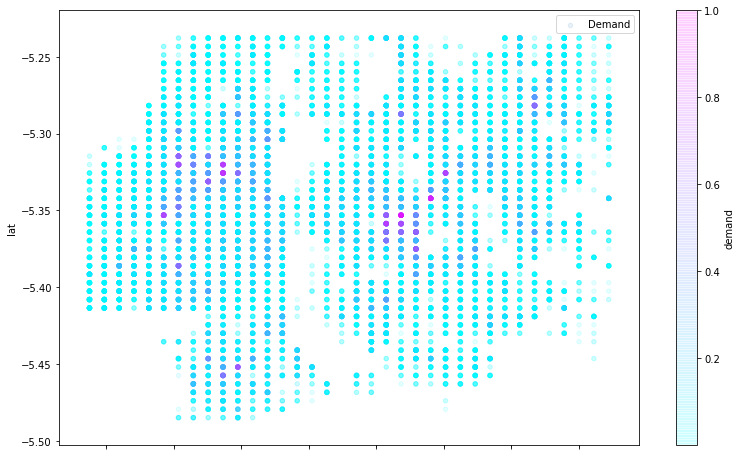

In [4]:
import geohash

def feature_lat(x):
    return geohash.decode(x)[0]

def feature_long(x):
    return geohash.decode(x)[1]

traffic_all['lat'] = traffic_all['geohash6'].apply(feature_lat)
traffic_all['long'] = traffic_all['geohash6'].apply(feature_long)
traffic_all = traffic_all.dropna()

#traffic_all.plot(kind="scatter", x="long", y="lat", alpha=0.1)

traffic_all.plot(kind="scatter", x="long", y="lat", alpha=0.1, label="Demand", figsize=(13,8),
    c="demand", cmap=plt.get_cmap("cool"), colorbar=True
)

There are several clusters of hotspots in the data set. 

In [5]:
traffic_all["day_of_week"] = traffic_all.apply(lambda x: x.day%7, axis=1)

#look for correlation based on the features we added
corr_matrix = traffic_all.corr()
corr_matrix["demand"].sort_values(ascending=False)

demand         1.000000
day            0.019715
day_of_week   -0.014557
lat           -0.027452
long          -0.028174
hour          -0.082323
Name: demand, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a33051cc0>,
      dtype=object)

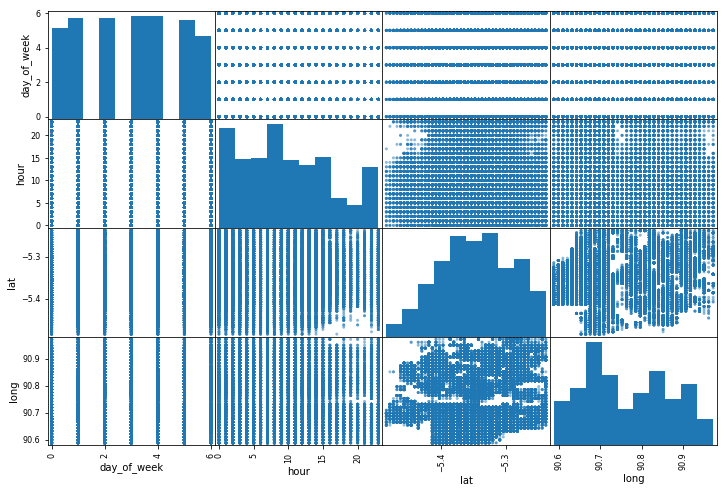

In [6]:
from pandas.plotting import scatter_matrix
attributes = ["day_of_week", "hour", "lat", "long"]
scatter_matrix(traffic_all[attributes], figsize=(12, 8))

There doesn't seem to be significant correlation between the attributes here.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42063 entries, 389680 to 377277
Data columns (total 8 columns):
geohash6       42063 non-null object
day            42063 non-null int64
timestamp      42063 non-null object
demand         42063 non-null float64
hour           42063 non-null float64
lat            42063 non-null float64
long           42063 non-null float64
day_of_week    42063 non-null int64
dtypes: float64(4), int64(2), object(2)
memory usage: 2.9+ MB


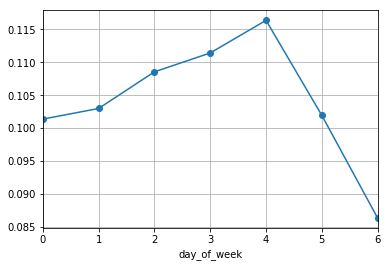

In [7]:
traffic_all.info()
traffic_all.groupby(['day_of_week']).mean()['demand'].plot(kind='line',marker='o',grid=True)

The graph above seems to indicate that the daily count start from 0=Monday.
I am expecting Saturday and Sunday to be on low demand because most passenger will not be as active.
Assume day_of_week=5, 6 to be weekend

In [8]:
def feature_weekday_weekend(x):
    if(x == 5 or x == 6):
        return 1
    return 0

traffic_all['weekend'] = traffic_all['day_of_week'].apply(feature_weekday_weekend)
traffic_all.head(n=5)

,geohash6,day,timestamp,demand,hour,lat,long,day_of_week,weekend
389680,qp09dd,14,23:45,0.190795,23.0,-5.347595,90.818481,0,0
3280669,qp092s,34,17:45,0.013596,17.0,-5.380554,90.730591,6,1
2747709,qp090w,19,23:45,0.002818,23.0,-5.413513,90.730591,5,1
3511903,qp09u9,56,11:00,0.008326,11.0,-5.309143,90.906372,0,0
606461,qp09gs,29,09:00,0.065520,9.0,-5.292664,90.862427,1,0


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is depreca

Number of clusters: 58


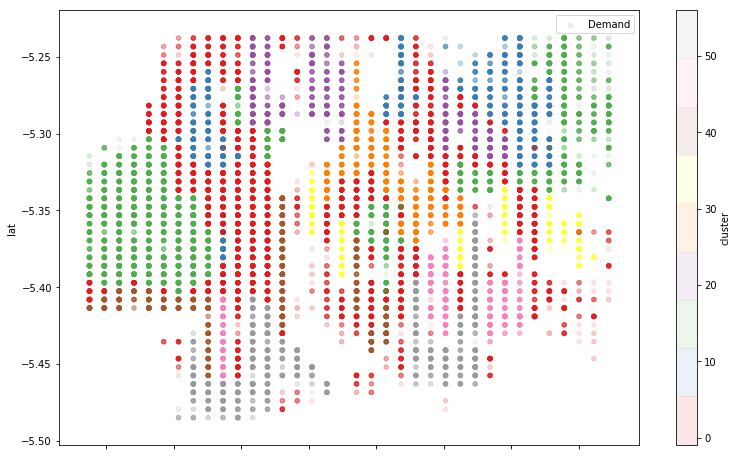

In [9]:
import hdbscan

coords = traffic_all.as_matrix(columns=['lat', 'long'])

kms_per_radian = 6371.0088
epsilon = 1.22 / kms_per_radian
db = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=20,  metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

traffic_all['cluster'] = db.labels_.tolist()

traffic_all.plot(kind="scatter", x="long", y="lat", alpha=0.1, label="Demand", figsize=(13,8),
    c="cluster", cmap=plt.get_cmap("Set1"), colorbar=True)


The clustering result above doesn't really yield useful method so we will be dropping it.

In [10]:
traffic_all.drop(columns='cluster')

,geohash6,day,timestamp,demand,hour,lat,long,day_of_week,weekend
389680,qp09dd,14,23:45,0.190795,23.0,-5.347595,90.818481,0,0
3280669,qp092s,34,17:45,0.013596,17.0,-5.380554,90.730591,6,1
2747709,qp090w,19,23:45,0.002818,23.0,-5.413513,90.730591,5,1
3511903,qp09u9,56,11:00,0.008326,11.0,-5.309143,90.906372,0,0
606461,qp09gs,29,09:00,0.065520,9.0,-5.292664,90.862427,1,0
3758482,qp09gy,47,07:45,0.079685,7.0,-5.281677,90.873413,5,1
3696972,qp09dn,45,12:30,0.139374,12.0,-5.325623,90.796509,3,0
564587,qp09ss,50,22:30,0.005829,22.0,-5.336609,90.906372,1,0
2191541,qp09kt,28,01:45,0.112267,1.0,-5.375061,90.906372,0,0
1405314,qp0d4y,56,05:30,0.022915,5.0,-5.237732,90.829468,0,0


Start building and test various Scikit Learn algorithm

In [11]:
traffic_all.head()
traffic_all = traffic_all[['geohash6','day','timestamp','hour','lat','long','day_of_week','weekend','demand']]
traffic_all.head()

,geohash6,day,timestamp,hour,lat,long,day_of_week,weekend,demand
389680,qp09dd,14,23:45,23.0,-5.347595,90.818481,0,0,0.190795
3280669,qp092s,34,17:45,17.0,-5.380554,90.730591,6,1,0.013596
2747709,qp090w,19,23:45,23.0,-5.413513,90.730591,5,1,0.002818
3511903,qp09u9,56,11:00,11.0,-5.309143,90.906372,0,0,0.008326
606461,qp09gs,29,09:00,9.0,-5.292664,90.862427,1,0,0.065520


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

#We take hour, lat, long, day_of_week and weekend for the training data
traffic_data = traffic_all.iloc[:, 3:-1].values
traffic_label = traffic_all.iloc[:, -1].values

xTrain, xTest, yTrain, yTest = train_test_split(traffic_data, traffic_label, test_size = 1/3, random_state = 0)

#adjusted to 40 and 300 based on GridSearchCV result
rf_regressor = RandomForestRegressor(max_depth=40,  n_estimators=300)
rf_regressor.fit(X=xTrain,y=yTrain)

y_reg_test_predict = rf_regressor.predict(xTest)

print("RandomForestRegressor MSE:", mean_squared_error(yTest, y_reg_test_predict))

feature_importances = rf_regressor.feature_importances_.argsort()[::-1][:len(rf_regressor.feature_importances_)]
print("Most important: feature "+ str(feature_importances[0]))


RandomForestRegressor MSE: 0.004092753602122741
Most important: feature 1


In [13]:
ada_regressor = AdaBoostRegressor(n_estimators=200)
ada_regressor.fit(X=xTrain,y=yTrain)

y_reg_test_predict = ada_regressor.predict(xTest)

print("AdaBoostRegressor MSE:", mean_squared_error(yTest, y_reg_test_predict))

feature_importances = ada_regressor.feature_importances_.argsort()[::-1][:len(ada_regressor.feature_importances_)]
print("Most important: feature "+ str(feature_importances[0]))

AdaBoostRegressor MSE: 0.02495618644285804
Most important: feature 1


In [14]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(X=xTrain,y=yTrain)

y_reg_test_predict = dt_regressor.predict(xTest)

print("DecisionTreeRegressor MSE:", mean_squared_error(yTest, y_reg_test_predict))

feature_importances = dt_regressor.feature_importances_.argsort()[::-1][:len(dt_regressor.feature_importances_)]
print("Most important: feature "+ str(feature_importances[0]))


DecisionTreeRegressor MSE: 0.007393249110835406
Most important: feature 2


In [15]:
gb_regressor = GradientBoostingRegressor()
gb_regressor.fit(X=xTrain,y=yTrain)

y_reg_test_predict = gb_regressor.predict(xTest)

print("GradientBoostingRegressor MSE:", mean_squared_error(yTest, y_reg_test_predict))

feature_importances = gb_regressor.feature_importances_.argsort()[::-1][:len(gb_regressor.feature_importances_)]
print("Most important: feature "+ str(feature_importances[0]))


GradientBoostingRegressor MSE: 0.016460437020408378
Most important: feature 1


In [16]:
hb_regressor = HuberRegressor()
hb_regressor.fit(X=xTrain,y=yTrain)

y_reg_test_predict = hb_regressor.predict(xTest)

print("HuberRegressor MSE:", mean_squared_error(yTest, y_reg_test_predict))


HuberRegressor MSE: 0.025175945066542627


Create the function to predict test set. It will rebuild the model based on the input trainingSetPath and predict on testSetPath

The dataset and features performed best on RandomForestRegressor. We try to get the best parameters.

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
	'n_estimators': [10, 50, 100,150,300],
	'max_depth' : [8,10,15,20,40]
}
CV_rfc = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv= 10)
CV_rfc.fit(X=xTrain,y=yTrain)

print ("Random Forest Regressor best_params_ : " + str(CV_rfc.best_params_))
print ("Random Forest Regressor best_score_ : " + str(CV_rfc.best_score_))

Random Forest Regressor best_params_ : {'max_depth': 40, 'n_estimators': 300}
Random Forest Regressor best_score_ : 0.8311952774794799
